<a href="https://colab.research.google.com/github/Hattinger04/KerasProjects/blob/master/Digit_Recognition/Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Digit Recognition
Dataset: MNISTs Digit Recognition Dataset\
Solution with Convolutional Neural Networks (CNN)

##   Managing Imports

In [142]:
# libraries to analyse and format data:
import numpy as np
import pandas as pd

# installing library without textoutput (we probably won't need this library but it's still nice to know of its existance)
%pip install pandas_profiling --quiet
import pandas_profiling as pp

# library to convert images to arrays and vice versa
from PIL import Image

# library to create graphs
import matplotlib.pyplot as plt

# libraries to visualize later results
import seaborn as sns
from sklearn.metrics import confusion_matrix

# libraries for developing an neural network
from keras.backend import argmax
from keras.models import load_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, SpatialDropout2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist # get dataset from keras library

## Importing needed data




Here we will differentiate between train and test sets and between x and y:

*   The train set is a list of images with which we will train our network
*   The test set is also a list of images with which we will check our network regarding accuracy and loss though
*   An "X" set is a set, which will be given to the network
*   An "Y" set is the solution of the prediction to the refering object in the X set

In [125]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Analyse imported data

In [148]:
number_classes = 10 # numbers between 0 and 9

labels = np.arange(0,10).astype(str) # create the labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U21')

In [127]:
# Dimension des Arrays ansehen
x_train.shape

(60000, 28, 28)

Explanation of this "weird" shape:


*   60000: number of entries / images
*   28, 28: The size of the image

In [128]:
# creating variable for image shape
IMAGE_SHAPE = (x_train.shape[1], x_train.shape[2], 1) # 1 because these images are not rgb but only grey values
IMAGE_SHAPE

(28, 28, 1)

In [129]:
# View an example of the dataset:
Image.fromarray(x_train[0])

In [130]:
# print the label to this image -> which is the value our model should predict in the future:
y_train[0]

5

## Format the data

In [131]:
# do one-hot encoding: when having multiple classification, you must use one-hot encoding (1 stands for the target, all other values are 0)
# therefore we need to transform our labels from a one-dimensional array to a number_of_classes-dimensional array, where the correct label is represented as a 1 and all the others as a zero
print(y_train.shape)
y_train = to_categorical(y_train, number_classes)
y_test_untouched = y_test.copy() # we will need these later for visualization of the data
y_test = to_categorical(y_test, number_classes)

print(y_train.shape)

(60000,)
(60000, 10)


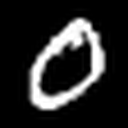

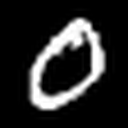

In [132]:
# normalize the data by substracting the mean acitivity and diciding by their standard deviation
# -> now we have much lower values in our array (easier for the neural network to handle -> otherwise slower)

image_before = Image.fromarray(x_train[1])

mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)
x_train = (x_train - mean_px)/(std_px)

image_after = Image.fromarray((((x_train-x_train.min())/(x_train.max()-x_train.min())*255)[1]).astype(np.uint8)) # reversing this process for demonstration

image_before.resize((128, 128), Image.ANTIALIAS).show()
image_after.resize((128, 128), Image.ANTIALIAS).show()

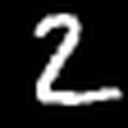

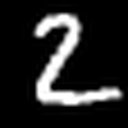

In [133]:
# The same with our test set:

image_before = Image.fromarray(x_test[1])

mean_px = x_test.mean().astype(np.float32)
std_px = x_test.std().astype(np.float32)
x_test = (x_test - mean_px)/(std_px)

image_after = Image.fromarray((((x_test-x_test.min())/(x_test.max()-x_test.min())*255)[1]).astype(np.uint8))

image_before.resize((128, 128), Image.ANTIALIAS).show()
image_after.resize((128, 128), Image.ANTIALIAS).show()

## Create the neural network

In [134]:
%%script false --no-raise-error
model = Sequential() # layers in this model are attached to the following layer

# in the first layer you must have an input_shape!

# adding a convolutional layer with 32 filters (can be compared to the neurons in a ANN)
# (1,1) is the kernel size which is the size of the 2D convolution window - must be an odd integer!
#   the bigger the kernel size the faster you are learning (usage depending on size of image!)
# set relu as the activation function
model.add(Conv2D(32, (1,1), activation="relu", input_shape=(IMAGE_SHAPE))) # adding a convolutional layer
# batch normalization: normalizes each layer's inputs by using mean and variance of the values in the current batch
# -> speeds up training (higher training rates possible) and makes it easier (easier weight initialization)
model.add(BatchNormalization())


# padding is used to guarantee that the input data has the size and shape which the model anticipates (filled with 0s)
model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
# max pooling calculates the largest value in each patch of each feature map - makes the network much faster and efficient
# more than (2,2) result in a great loss of data!
model.add(MaxPooling2D((2, 2))) # input image now only half in size
# with spatial dropout we randomly drop entire feature maps instead of individual elements
#  (adjacent pixels within feature maps are normally strongly correlated -> regular dropout won't regularize the actiavtions)
model.add(SpatialDropout2D(0.2))


model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(BatchNormalization())

# flatten makes two-dimensional array into a one-dimensional array
model.add(Flatten())
# dropout drops some layer outputs at random during training to avoid overfitting
#  (avoid redundance details of inputs and the network can't rely on one input - it might be dropped out)
model.add(Dropout(0.25))
model.add(Dense(64, activation="relu"))
model.add(Dense(number_classes, activation="softmax")) # output layer!

model.summary()

In [135]:
# Compiling the models

# loss is the value of how wrong the network has been
# the optimizer is the function how the network "learns" by using the calculated loss
# the metrics are to judge the performance of the model but are not used in training
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## Train the neural network


In [136]:
%%script false --no-raise-error

# the batch size is the number of samples processed before the model is updated
#   (e.g.: many points are added to a coordinate system at once and then a linear function to describe these points will be set)
batch_size = 64
# epochs are synonym to the iterations the network will iterate through all the training data
epochs = 5

# now training the model:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Text(0, 0.5, 'Accuracy [%]')

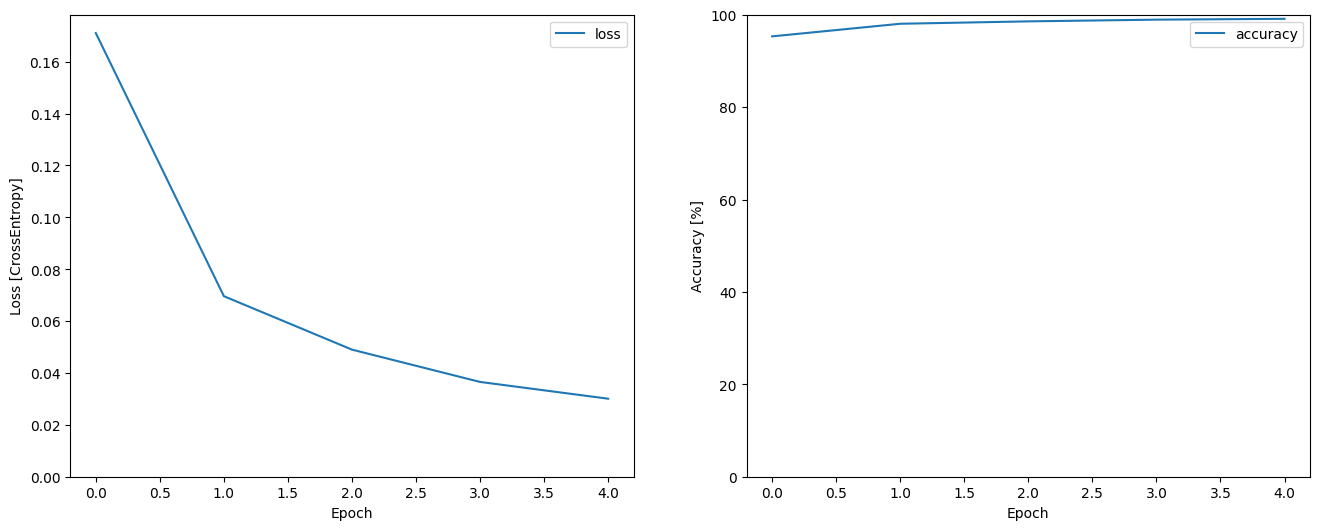

In [137]:
metrics = history.history # get data to create a graph

plt.figure(figsize=(16,6)) # create plot

plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Test the neural network

In [138]:
# evaluate the model by testing it on the test set
score = model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0450 - accuracy: 0.9863


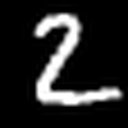

Correct label:  2
1/1 [==============================] - 0s 35ms/step
Predicted percentages:  [[1.9566068e-14 9.2780887e-11 1.0000000e+00 1.9180355e-13 8.7423075e-16
  2.6756246e-14 4.5021170e-10 1.5822074e-10 4.0346593e-12 1.0425915e-16]]
Predicted label:  2


In [151]:
# show one example from the test set (using the first one):
image_after.resize((128, 128), Image.ANTIALIAS).show()

print("Correct label: ", labels[np.argmax(y_test[1])]) # image_after is the image at index 1 in the test set

# prediction:
# prepare image:
testimage = x_test[1].copy()
testimage = np.expand_dims(testimage, axis=0) # add the feature as dim to array
prediction = model.predict(testimage)

print("Predicted percentages: ", prediction)
print("Predicted label: ", labels[np.argmax(prediction)])

313/313 [==============================] - 1s 2ms/step


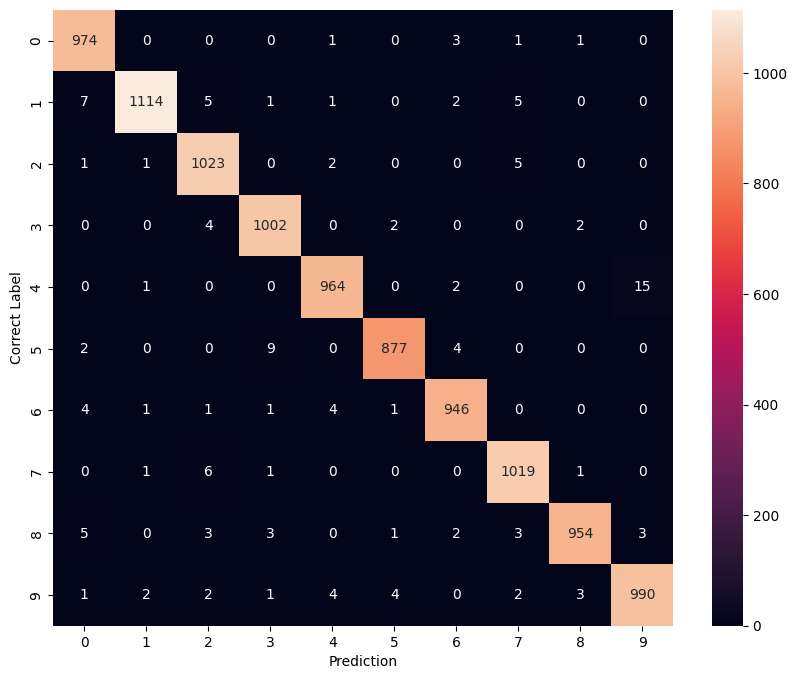

In [152]:
# create a heatmap by using a confusion matrix
y_pred = model.predict(x_test)
y_pred = argmax(y_pred) # get the predicted value
confusion_mtx =  confusion_matrix(y_test_untouched, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Correct Label')
plt.show()

## Save the neural network

In [ ]:
# recommended format by keras => .keras
model.save("digit_recognition.keras")

# loading the model (not needed here):
new_model = load_model("digit_recognition.keras")
new_model.summary()